<a href="https://colab.research.google.com/github/JNK234/Fast.ai-Projects/blob/master/Object%20Detection/Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade
!pip install nbdev

In [78]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

In [2]:
path = untar_data(URLs.PASCAL_2012)

In [3]:
path.ls()

(#6) [Path('/root/.fastai/data/pascal_2012/train'),Path('/root/.fastai/data/pascal_2012/train.csv'),Path('/root/.fastai/data/pascal_2012/segmentation'),Path('/root/.fastai/data/pascal_2012/test'),Path('/root/.fastai/data/pascal_2012/train.json'),Path('/root/.fastai/data/pascal_2012/valid.json')]

## Load Data

In [4]:
train_df = pd.read_csv(path/'train.csv')

In [5]:
train_df

,fname,labels,is_valid
0,2008_000002.jpg,tvmonitor,True
1,2008_000003.jpg,train person,True
2,2008_000007.jpg,boat,True
3,2008_000008.jpg,horse person,False
4,2008_000009.jpg,cow,True
...,...,...,...
11535,2011_003269.jpg,car,True
11536,2011_003271.jpg,bottle,True
11537,2011_003274.jpg,train,False
11538,2011_003275.jpg,aeroplane,True


In [6]:
train_images, train_lbl_bbox = get_annotations(path/'train.json')
valid_images, valid_lbl_bbox = get_annotations(path/'valid.json')

In [7]:
type(train_images), type(train_lbl_bbox), len(train_images), len(train_lbl_bbox)

(list, list, 5717, 5717)

In [8]:
type(valid_images), type(valid_lbl_bbox), len(valid_images), len(valid_lbl_bbox)

(list, list, 5823, 5823)

In [9]:
print("No of train images :", len(train_images))
print("Len of train Lbl Boxes :", len(train_lbl_bbox))
print()
print("No of valid images :", len(valid_images))
print("Len of valid Lbl Boxes :", len(valid_lbl_bbox))

No of train images : 5717
Len of train Lbl Boxes : 5717

No of valid images : 5823
Len of valid Lbl Boxes : 5823


In [10]:
print(train_images[0], train_lbl_bbox[0])
print(valid_images[0], valid_lbl_bbox[0])

2008_000008.jpg ([[52, 86, 471, 420], [157, 43, 289, 167]], ['horse', 'person'])
2008_000002.jpg ([[33, 10, 448, 293]], ['tvmonitor'])


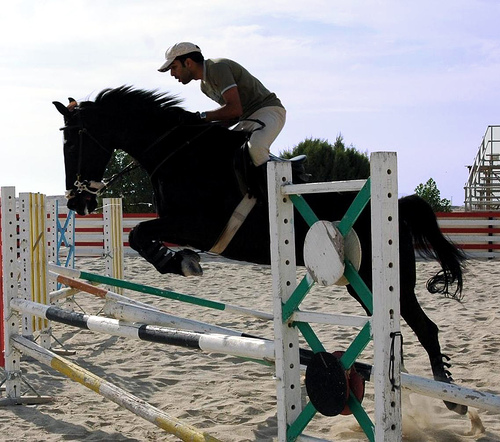

In [11]:
PILImage.create(path/'train/2008_000008.jpg')

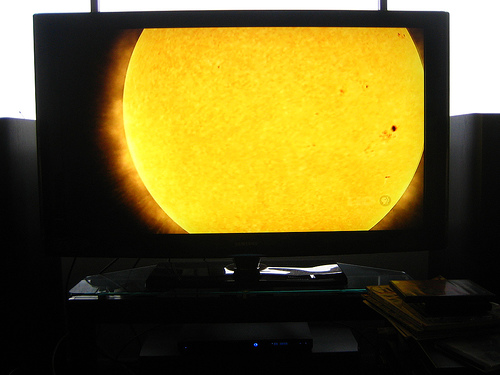

In [12]:
PILImage.create(path/'train/2008_000002.jpg')

In [13]:
images = []
lbl_boxes = []

In [14]:
images.extend(train_images)
images.extend(valid_images)

lbl_boxes.extend(train_lbl_bbox)
lbl_boxes.extend(valid_lbl_bbox)

In [15]:
img2bbox = dict(zip(images, lbl_boxes))

In [16]:
first = {k:img2bbox[k] for k in list(img2bbox)[:1]}

In [17]:
first

{'2008_000008.jpg': ([[52, 86, 471, 420], [157, 43, 289, 167]],
  ['horse', 'person'])}

## DataBlock and DataLoader

In [24]:
def get_x(df):
    return path/'train'/df['fname']

def get_bboxes(df):
    return img2bbox[df['fname']][0]

def get_bbox_labels(df):
    return img2bbox[df['fname']][1]

In [35]:
pascal = DataBlock(
    blocks = (ImageBlock, BBoxBlock, BBoxLblBlock),
    get_x = get_x,
    get_y = [get_bboxes, get_bbox_labels],
    splitter = ColSplitter('is_valid'),
    item_tfms = Resize(420),
    n_inp = 1
)

In [68]:
dls = pascal.dataloaders(train_df, bs=16)

<Figure size 720x720 with 0 Axes>

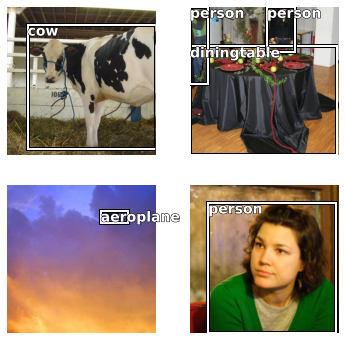

In [69]:
plt.figure(figsize=(10,10))
dls.train.show_batch(max_n=4)

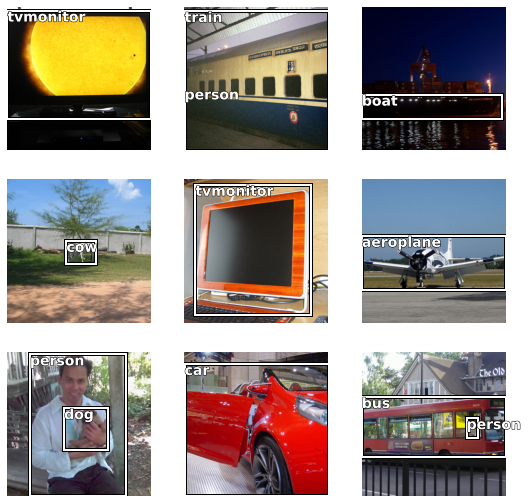

In [70]:
dls.valid.show_batch()

In [71]:
len(dls.vocab)

21

In [73]:
dls.c = 20

## Model

In [ ]:
!pip install wwf

In [44]:
from wwf.vision.object_detection import *

In [47]:
encoder = create_body(resnet34, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [54]:
get_c(dls)

20

In [56]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [57]:
arch

RetinaNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [58]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=248, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

In [59]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [60]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [61]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## Loss Function

In [62]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

In [63]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

In [64]:
def _retinanet_split(m): 
    return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [74]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [75]:
learn.freeze()

In [ ]:
torch.cuda.empty_cache()
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

In [79]:
learn.unfreeze()

In [82]:
learn.predict(path/'test'/'2010_001222.jpg')

epoch,train_loss,valid_loss,time


TypeError: ignored

In [ ]:
)